# Fingerprint keypoints detector

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import re
import glob
import time
import random
import math

import cv2 as cv
import PIL as pl
import imageio as imgio
import h5py

import tensorflow as tf
from tensorflow import keras as krs
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from google.colab import drive
from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

Using TensorFlow backend.


### 1. Downloading dataset

In [0]:
!wget -O Task.zip 'https://doc-04-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/80aaarkn3vrrsn5im3sh9n5pbbk1mb9v/1571169600000/05645080036027136522/*/1wnuGzUnE3-7bDASoAIc-P5IBrhnynaJR?e=download'
!unzip Task.zip

In [0]:
!ls
!rm Task.zip

In [80]:
# uses it if previous method is not works (Task.zip shoulde be in Google Drive)
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
!cp '/gdrive/My Drive/Task.zip' .
!unzip Task.zip
!ls

Archive:  Task.zip
   creating: images/
  inflating: images/2000000000033720_RM.jpg  
  inflating: images/2000000000033720_RR.jpg  
  inflating: images/2000000000033720_RT.jpg  
  inflating: images/2000000000033721_LI.jpg  
  inflating: images/2000000000033721_LL.jpg  
  inflating: images/2000000000033721_LM.jpg  
  inflating: images/2000000000033721_LR.jpg  
  inflating: images/2000000000033721_LT.jpg  
  inflating: images/2000000000033721_RI.jpg  
  inflating: images/2000000000033721_RL.jpg  
  inflating: images/2000000000033721_RM.jpg  
  inflating: images/2000000000033721_RR.jpg  
  inflating: images/2000000000033721_RT.jpg  
  inflating: images/2000000000033722_LI.jpg  
  inflating: images/2000000000033722_LL.jpg  
  inflating: images/2000000000033722_LM.jpg  
  inflating: images/2000000000033722_LR.jpg  
  inflating: images/2000000000033722_LT.jpg  
  inflating: images/2000000000033722_RI.jpg  
  inflating: images/2000000000033722_RL.jpg  
  inflating: images/2000000000033722_RM.

In [0]:
#!cp '/gdrive/My Drive/fingerprint_keypoints_detector.h5' .

In [0]:
#!rm 'fingerprint_keypoints_detector.h5'

In [82]:
!ls

adc.json			   images_aug	      patches	   sample_data
fingerprint_keypoints_detector.h5  images_aug_masked  patches_aug  Task.zip
images				   images_masked      points	   ToDo.txt


In [0]:
#!rm -r images_aug
#!rm -r images_aug_masked

In [0]:
seed = 666
patch_size = (17, 17)
superpoint_size = (9, 9)

In [0]:
np.random.seed(seed)
random.seed(seed)
ds_images_path = "./images"
ds_images_aug_path = "./images_aug"
ds_labels_path = "./points"
ds_patches_path = "./patches"
ds_patches_aug_path = "./patches_aug"
ds_images_masked_path = "./images_masked"
ds_images_aug_masked_path = "./images_aug_masked"
images_paths = glob.glob(os.path.join(ds_images_path, "*.jpg"))
labels_paths = {(os.path.basename(path)).split(".")[0]: path for path in glob.glob(os.path.join(ds_labels_path, "*.txt"))}

In [0]:
if not os.path.exists(ds_patches_path):
    os.makedirs(ds_patches_path)

if not os.path.exists(ds_patches_aug_path):
    os.makedirs(ds_patches_aug_path)
    
if not os.path.exists(ds_images_masked_path):
    os.makedirs(ds_images_masked_path)

if not os.path.exists(ds_images_aug_path):
    os.makedirs(ds_images_aug_path)

if not os.path.exists(ds_images_aug_masked_path):
    os.makedirs(ds_images_aug_masked_path)

### 2. Preview

In [0]:
def show_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="gray")
    plt.show()

def get_sample(image_path, label_path):
    image_arr = np.array(imgio.imread(image_path), dtype=np.float32) / 255.0
    label_arr = pd.read_csv(label_path, "\t", header=None).values
    return image_arr, label_arr

def show_sample(image_path, label_path, figsize=(15, 15), title=None):
    image_sample, label_sample = get_sample(image_path, label_path)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(image_sample, cmap="gray")
    ax.scatter(label_sample[:, 0], label_sample[:, 1], marker='o', c='red', s=15)
    if title is not None:
      ax.title.set_text(title)
    plt.show()
    
    print("Image path: ", image_path)
    print("Image size: ", image_sample.shape)
    print("Num points: ", len(label_sample))

def show_sample2(image_sample, label_sample, figsize=(15, 15), title=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(image_sample, cmap="gray")
    ax.scatter(label_sample[:, 0], label_sample[:, 1], marker='o', c='red', s=15)
    if title is not None:
      ax.title.set_text(title)
    plt.show()
    
    print("Image size: ", image_sample.shape)
    print("Num points: ", len(label_sample))

def show_test_sample(plots_shape, images, label, figsize=(30, 60), titles=None):
  fig, axes = plt.subplots(plots_shape[0], plots_shape[1], figsize=figsize)

  i = 0
  for ax in axes:
    ax.imshow(images[i], cmap="gray")
    ax.scatter(label[:, 0], label[:, 1], marker='o', c="red", s=15)
    if titles is not None:
      ax.title.set_text(titles[i])
    i += 1
    
  plt.show()

def show_keypoints(image, keypts1, keypts2, figsize=(15, 15), title=None):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  ax.imshow(image, cmap="gray")
  ax.scatter(keypts1[:, 0], keypts1[:, 1], marker='x', c='red', s=30)
  ax.scatter(keypts2[:, 0], keypts2[:, 1], marker='x', c='green', s=30)
  if title is not None:
    ax.title.set_text(title)
  plt.show()
    
  print("Num points (red): ", len(keypts1))
  print("Num points (green): ", len(keypts2))

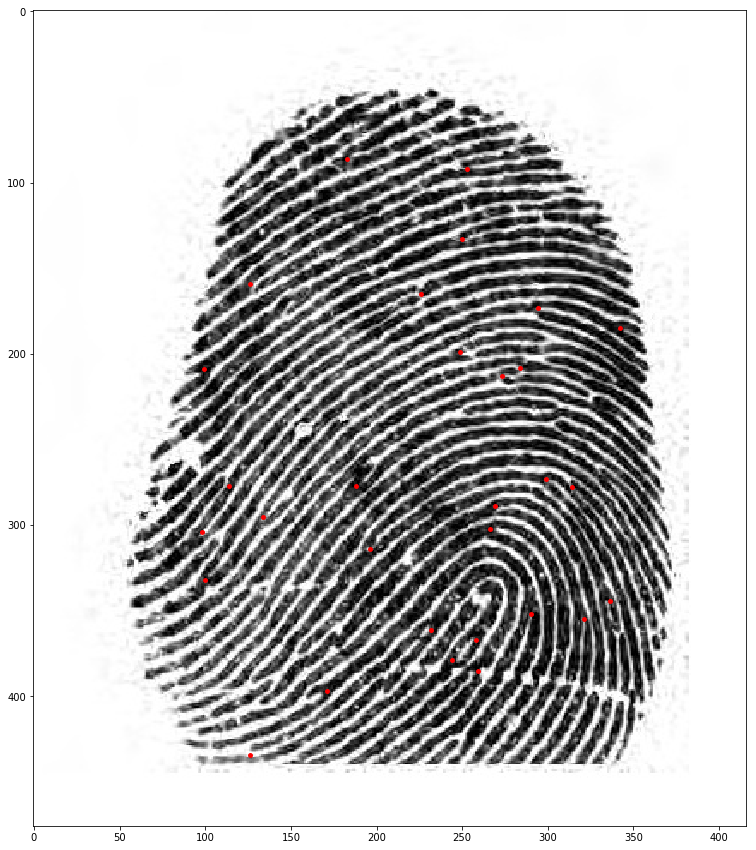

Image path:  ./images/2000000000033977_LT.jpg
Image size:  (476, 416)
Num points:  30


In [9]:
# show random sample
image_sample_path = np.random.choice(images_paths)
label_sample_path = labels_paths[os.path.basename(image_sample_path).split(".")[0]]
show_sample(image_sample_path, label_sample_path)

In [0]:
imgs_points = dict()
for img_path in images_paths:
    labe_path = os.path.basename(img_path).split(".")[0]
    img, labe = get_sample(img_path, labels_paths[labe_path])
    imgs_points[os.path.basename(img_path)] = (len(labe), img.shape[1], img.shape[0])

In [0]:
imgs_points_df = pd.DataFrame.from_dict(imgs_points, orient="index", columns=["points_num", "img_width", "img_height"])

In [12]:
imgs_points_df.head()

,points_num,img_width,img_height
2000000000034124_RR.jpg,26,344,576
2000000000033939_LR.jpg,21,296,388
2000000000033735_LT.jpg,29,440,556
2000000000033883_RM.jpg,26,360,596
2000000000033790_LM.jpg,33,392,556


In [13]:
imgs_points_df.describe()

,points_num,img_width,img_height
count,4067.000000,4067.000000,4067.000000
mean,23.101057,362.126383,516.900910
std,9.546910,52.404221,58.015304
min,2.000000,200.000000,280.000000
25%,16.000000,328.000000,484.000000
50%,22.000000,360.000000,520.000000
75%,29.000000,392.000000,552.000000
max,84.000000,544.000000,728.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73deec1f60>,
      dtype=object)

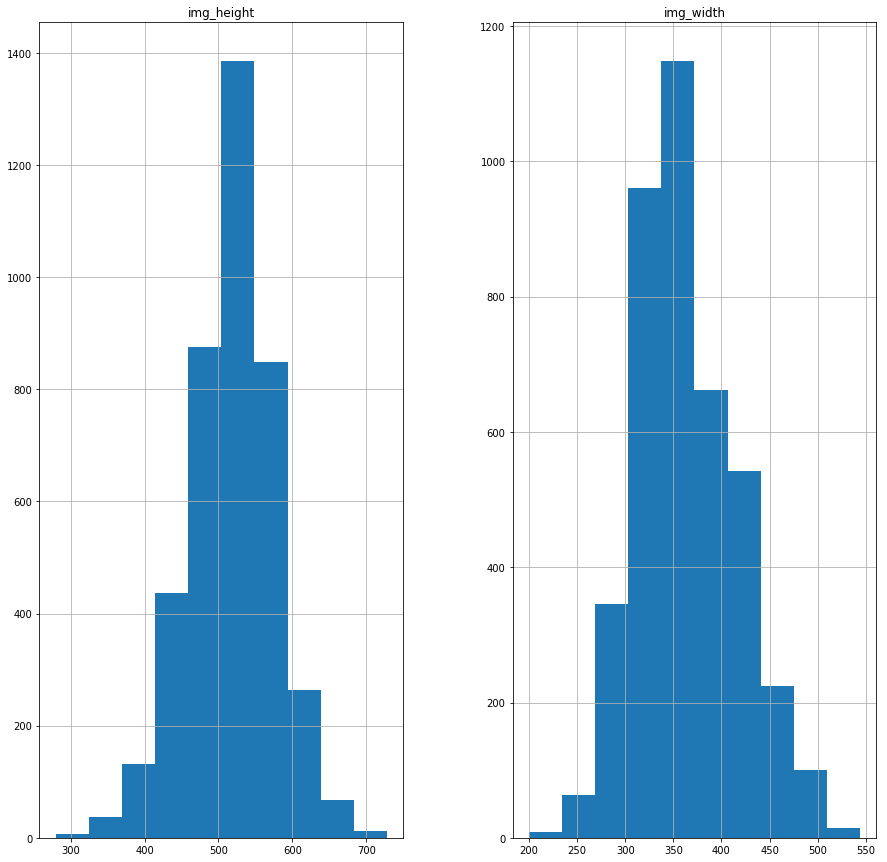

In [14]:
imgs_points_df.hist(column=["img_width", "img_height"], bins=10, figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73deca5f60>]],
      dtype=object)

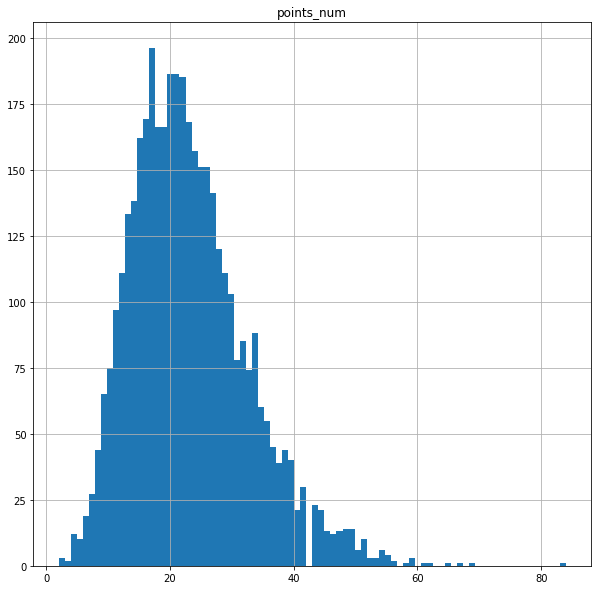

In [15]:
imgs_points_df.hist(column="points_num", bins=84, figsize=(10, 10))

### 3. Data generation&augmentation

#### 3.1 Generate ground truth data (masked images) based on full images for not-patch-like models

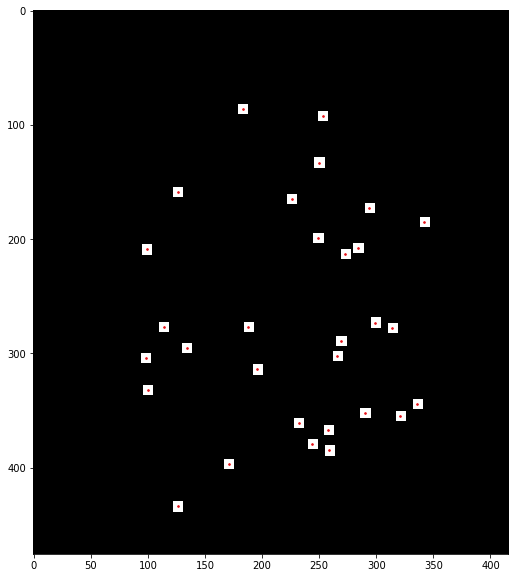

In [16]:
# show mask for training
img, labe = get_sample(image_sample_path, label_sample_path)
mask = np.zeros(img.shape, dtype=np.float32)
for p in labe:
    mask[p[1]-superpoint_size[1]//2:p[1]+(superpoint_size[0]//2)+1, 
         p[0]-superpoint_size[1]//2:p[0]+(superpoint_size[0]//2)+1] = 1.0

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mask, cmap="gray")
ax.scatter(labe[:, 0], labe[:, 1], marker='.', 
           edgecolors=['red'], s=10)
plt.show()

In [0]:
# generate training masks
if (len(os.listdir(ds_images_masked_path)) == 0):
    for img_path in images_paths:
        labe_path = os.path.basename(img_path).split(".")[0]
        img, labe = get_sample(img_path, labels_paths[labe_path])
        gt_mask = np.zeros(img.shape, dtype=np.float32)
        for p in labe:
            gt_mask[p[1]-superpoint_size[1]//2:p[1]+(superpoint_size[1]//2)+1, 
                    p[0]-superpoint_size[0]//2:p[0]+(superpoint_size[0]//2)+1] = 1.0
    
        imgio.imwrite(os.path.join(ds_images_masked_path, os.path.basename(img_path)), (gt_mask*255).astype(np.uint8))
        del img
        del gt_mask

In [0]:
# may be augmentations???
for img_path in images_paths:
  inp_img = np.array(imgio.imread(img_path), dtype=np.float32) / 255.0
  mask_img = np.array(imgio.imread(os.path.join(ds_images_masked_path, os.path.basename(img_path))), dtype=np.float32) / 255.0
  
  imgio.imwrite(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(0)+'.jpg'), (inp_img*255).astype(np.uint8))
  imgio.imwrite(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(0)+'.jpg'), (mask_img*255).astype(np.uint8))

  # horizontal flip
  imgio.imwrite(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(1)+'.jpg'), (inp_img[::1, ::-1]*255).astype(np.uint8))
  imgio.imwrite(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(1)+'.jpg'), (mask_img[::1, ::-1]*255).astype(np.uint8))

  # vertical flip
  #imgio.imwrite(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(2)+'.jpg'), (inp_img[::-1, ::1]*255).astype(np.uint8))
  #imgio.imwrite(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(2)+'.jpg'), (mask_img[::-1, ::1]*255).astype(np.uint8))

  # vertical and horizontal flip
  #imgio.imwrite(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(3)+'.jpg'), (inp_img[::-1, ::-1]*255).astype(np.uint8))
  #imgio.imwrite(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(3)+'.jpg'), (mask_img[::-1, ::-1]*255).astype(np.uint8))

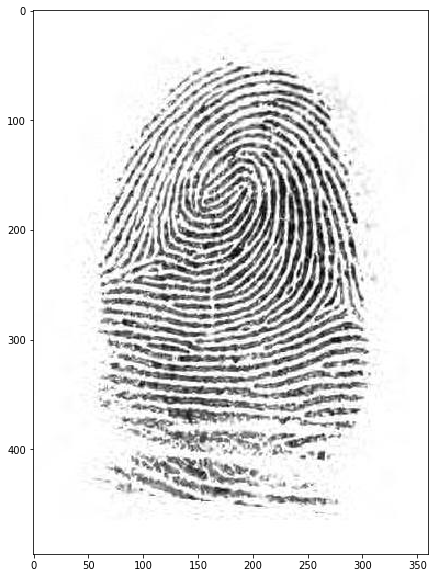

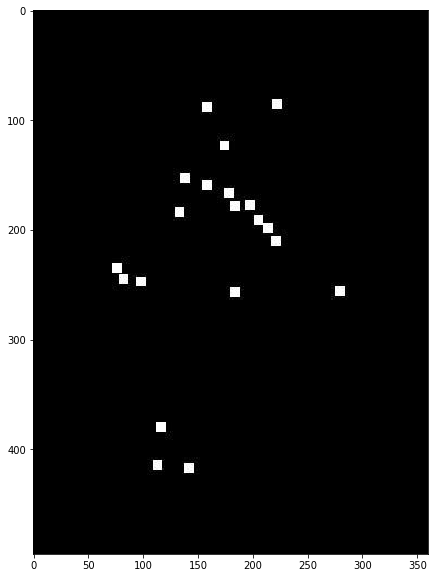

In [19]:
# test show augments
augs_imgs_paths = glob.glob(os.path.join(ds_images_aug_path, "*.jpg"))
raug_path = np.random.choice(augs_imgs_paths)
raug = np.array(imgio.imread(raug_path), dtype=np.float32) / 255.0
raugm = np.array(imgio.imread(os.path.join(ds_images_aug_masked_path, os.path.basename(raug_path))), dtype=np.float32) / 255.0
show_image(raug)
show_image(raugm)

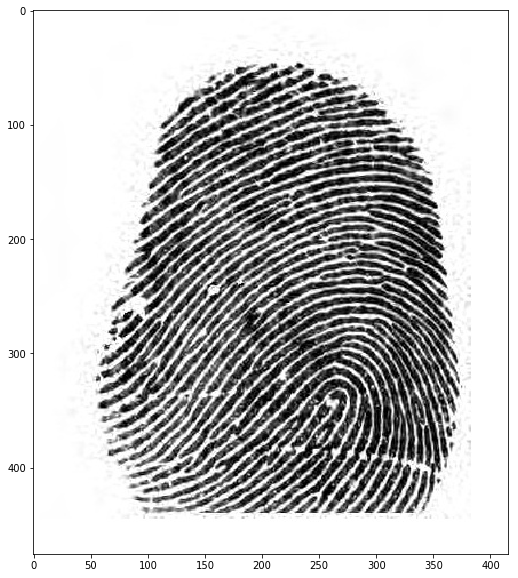

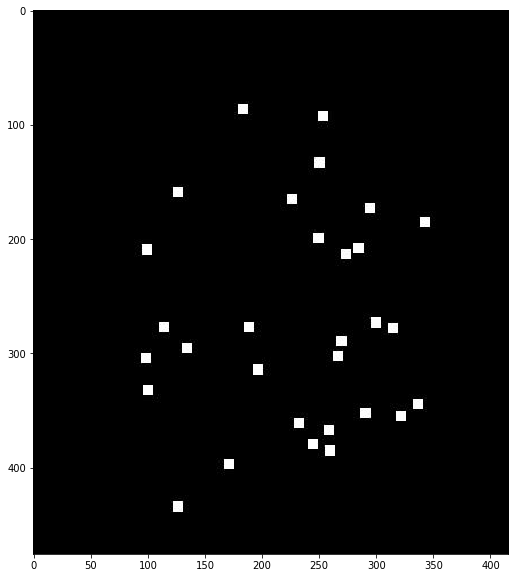

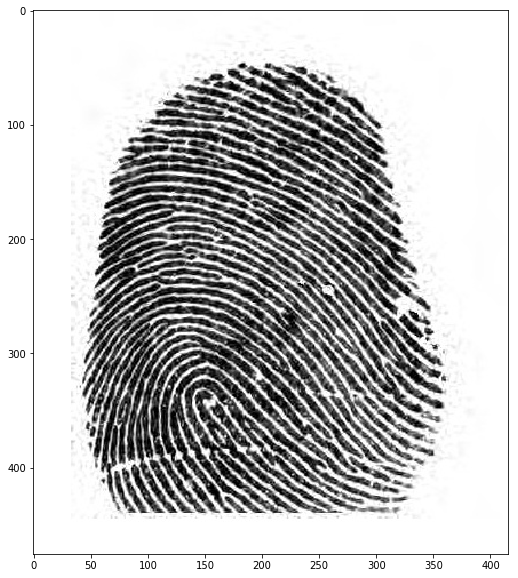

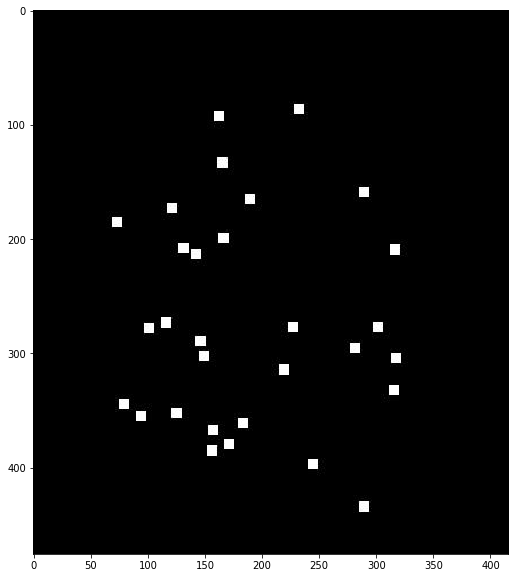

In [20]:
# show types of augmentations
inp_img = np.array(imgio.imread(image_sample_path), dtype=np.float32) / 255.0
mask_img = np.array(imgio.imread(os.path.join(ds_images_masked_path, os.path.basename(image_sample_path))), dtype=np.float32) / 255.0
show_image(inp_img)
show_image(mask_img)
# horizontal flip
show_image(inp_img[::1, ::-1])
show_image(mask_img[::1, ::-1])
# vertical flip
#show_image(inp_img[::-1, ::1])
#show_image(mask_img[::-1, ::1])
# vertical and horizontal flip
#show_image(inp_img[::-1, ::-1])
#show_image(mask_img[::-1, ::-1])

In [0]:
#show_sample(os.path.join(ds_images_masked_path, os.path.basename(image_sample_path)), label_sample_path)

#### 3.3 Spliting data

In [21]:
masks_paths = images_paths.copy()
masks_paths = [os.path.join(ds_images_masked_path, os.path.basename(x)) for x in masks_paths]
print(images_paths[0])
print(masks_paths[0])

./images/2000000000034124_RR.jpg
./images_masked/2000000000034124_RR.jpg


In [22]:
# splitting data on train, validation and test subsets
imgs_train, imgs_test, masks_train, masks_test = train_test_split(images_paths, masks_paths, test_size=0.15, 
                                                                  random_state=seed, shuffle=True)
imgs_train, imgs_val, masks_train, masks_val = train_test_split(imgs_train, masks_train, test_size=0.15, 
                                                                random_state=seed, shuffle=True)
print('train', len(imgs_train), len(masks_train))
print('val', len(imgs_val), len(masks_val))
print('test', len(imgs_test), len(masks_test))

train 2937 2937
val 519 519
test 611 611


In [0]:
aug_imgs_train = []
aug_masks_train = []
for img_path in imgs_train:
  aug_imgs_train.append(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(0)+'.jpg'))
  aug_masks_train.append(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(0)+'.jpg'))
  aug_imgs_train.append(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(1)+'.jpg'))
  aug_masks_train.append(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(1)+'.jpg'))
  #aug_imgs_train.append(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(2)+'.jpg'))
  #aug_masks_train.append(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(2)+'.jpg'))
  #aug_imgs_train.append(os.path.join(ds_images_aug_path, os.path.basename(img_path).split(".")[0]+str(3)+'.jpg'))
  #aug_masks_train.append(os.path.join(ds_images_aug_masked_path, os.path.basename(img_path).split(".")[0]+str(3)+'.jpg'))

In [0]:
imgs_train = aug_imgs_train
masks_train = aug_masks_train
random.shuffle(imgs_train)
masks_train = [os.path.join(ds_images_aug_masked_path, os.path.basename(x)) for x in imgs_train]

In [43]:
print('aug train', len(imgs_train), len(masks_train))
print('val', len(imgs_val), len(masks_val))
print('test', len(imgs_test), len(masks_test))

aug train 5874 5874
val 519 519
test 611 611


In [0]:
# defines image data generators

# determined generator
def gen_batch_fn(train_paths, gt_paths, image_shape):
    def get_batches_fn(batch_size):
        for batch_i in range(0, len(train_paths), batch_size):
            gt_dir_path = os.path.dirname(gt_paths[0])
            images = []
            gt_images = []
            for image_file in train_paths[batch_i:batch_i+batch_size]:
                gt_image_file = gt_paths[gt_paths.index(os.path.join(gt_dir_path, os.path.basename(image_file)))]

                image = cv.resize(np.array(imgio.imread(image_file),dtype=np.float32)/255.0, dsize=(image_shape[1], image_shape[0]))
                gt_image = cv.resize(np.array(imgio.imread(gt_image_file),dtype=np.float32)/255.0, dsize=(image_shape[1], image_shape[0]), interpolation=cv.INTER_NEAREST)
                gt_image = (gt_image > 0.5).astype(np.float32)
                
                image = image.reshape((image.shape[0], image.shape[1], 1))
                gt_image = gt_image.reshape((gt_image.shape[0], gt_image.shape[1], 1))
                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn

# infinity generator
def gen_batch_fn2(train_paths, gt_paths, image_shape):
    def get_batches_fn2(batch_size):
        while True:
          for batch_i in range(0, len(train_paths), batch_size):
            gt_dir_path = os.path.dirname(gt_paths[0])
            images = []
            gt_images = []
            for image_file in train_paths[batch_i:batch_i+batch_size]:
              gt_image_file = gt_paths[gt_paths.index(os.path.join(gt_dir_path, os.path.basename(image_file)))]

              image = cv.resize(np.array(imgio.imread(image_file),dtype=np.float32)/255.0, dsize=(image_shape[1], image_shape[0]))
              gt_image = cv.resize(np.array(imgio.imread(gt_image_file),dtype=np.float32)/255.0, dsize=(image_shape[1], image_shape[0]), interpolation=cv.INTER_NEAREST)
              gt_image = (gt_image > 0.5).astype(np.float32)
                
              image = image.reshape((image.shape[0], image.shape[1], 1))
              gt_image = gt_image.reshape((gt_image.shape[0], gt_image.shape[1], 1))
              images.append(image)
              gt_images.append(gt_image)
            
            yield np.array(images), np.array(gt_images)
    return get_batches_fn2

In [0]:
img_shape = (544, 384)

In [0]:
# testing generator
train_g = gen_batch_fn(imgs_train, masks_train, img_shape)(8)

In [0]:
img, gt_img = next(train_g)

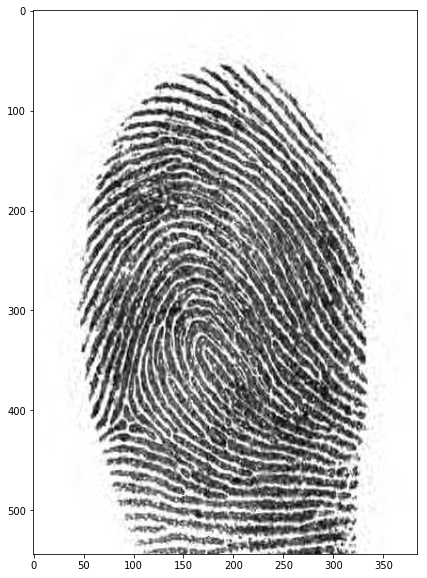

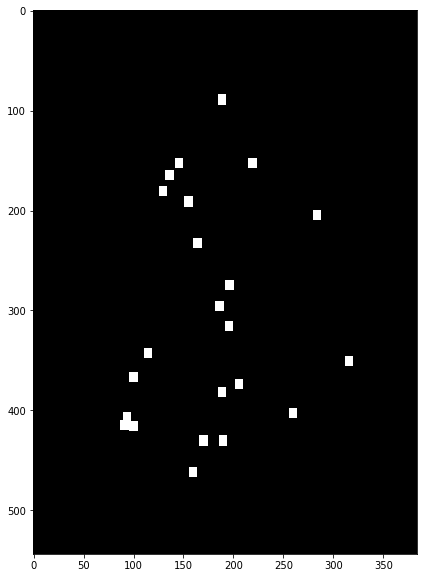

(544, 384)


In [31]:
plt.figure(figsize=(10, 10))
img = img[0].reshape((img[0].shape[0], img[0].shape[1]))
plt.imshow(img, cmap="gray")
plt.show()
gt_img = gt_img[0].reshape((gt_img[0].shape[0], gt_img[0].shape[1]))
plt.figure(figsize=(10, 10))
plt.imshow(gt_img, cmap="gray")
plt.show()
print(gt_img.shape)

### 4. Training&testing models

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    
    # second layer
    conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(conv)
    if batchnorm:
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    
    return conv

def unet(input_img, n_filters=64, dropout=0.5, batchnorm=True):
    # downsampling path,
    conv1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    pool1 = MaxPooling2D((2, 2)) (conv1)
    pool1 = Dropout(dropout*0.5)(pool1)

    conv2 = conv2d_block(pool1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    pool2 = MaxPooling2D((2, 2)) (conv2)
    pool2 = Dropout(dropout)(pool2)

    conv3 = conv2d_block(pool2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    pool3 = MaxPooling2D((2, 2)) (conv3)
    pool3 = Dropout(dropout)(pool3)

    conv4 = conv2d_block(pool3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (conv4)
    pool4 = Dropout(dropout)(pool4)
    
    conv5 = conv2d_block(pool4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # upsampling path
    upconv6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (conv5)
    upconv6 = concatenate([upconv6, conv4], axis=3)
    upconv6 = Dropout(dropout)(upconv6)
    conv6 = conv2d_block(upconv6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    upconv7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (conv6)
    upconv7 = concatenate([upconv7, conv3], axis=3)
    upconv7 = Dropout(dropout)(upconv7)
    conv7 = conv2d_block(upconv7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    upconv8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (conv7)
    u8 = concatenate([upconv8, conv2], axis=3)
    upconv8 = Dropout(dropout)(upconv8)
    conv8 = conv2d_block(upconv8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    upconv9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (conv8)
    upconv9 = concatenate([upconv9, conv1], axis=3)
    upconv9 = Dropout(dropout)(upconv9)
    conv9 = conv2d_block(upconv9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    output = Conv2D(1, (1, 1), activation='sigmoid') (conv9)
    model = Model(inputs=[input_img], outputs=[output])
    
    return model

In [0]:
# if exists pretrained model
model = load_model('fingerprint_keypoints_detector.h5')
model.summary()

In [51]:
# build model
input_img = Input((img_shape[0], img_shape[1], 1), name='img')
model = unet(input_img, n_filters=32, dropout=0.4, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 544, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 544, 384, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 544, 384, 32) 128         conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 544, 384, 32) 0           batch_normalization_73[0][0]     
____________________________________________________________________________________________

In [0]:
train_gen = gen_batch_fn2(imgs_train, masks_train, img_shape)
val_gen = gen_batch_fn2(imgs_val, masks_val, img_shape)
test_gen = gen_batch_fn2(imgs_test, masks_test, img_shape)
epochs = 8
batch_size = 10

In [0]:
chp = ModelCheckpoint(filepath='./fingerprint_keypoints_detector.h5', monitor='val_acc', verbose=1, save_best_only=True)
est = EarlyStopping(patience=2, monitor='val_acc', verbose=1)

In [54]:
model.fit_generator(train_gen(batch_size), steps_per_epoch=len(imgs_train)//batch_size, 
                    epochs=epochs, validation_data=val_gen(batch_size), 
                    validation_steps=len(imgs_val)//batch_size, callbacks=[chp, est])

Epoch 1/8
587/587 [==============================] - 1049s 2s/step - loss: 0.1002 - acc: 0.9830 - val_loss: 0.0494 - val_acc: 0.9900

Epoch 00001: val_acc improved from -inf to 0.98996, saving model to ./fingerprint_keypoints_detector.h5
Epoch 2/8
587/587 [==============================] - 1049s 2s/step - loss: 0.0387 - acc: 0.9904 - val_loss: 0.0319 - val_acc: 0.9909

Epoch 00002: val_acc improved from 0.98996 to 0.99092, saving model to ./fingerprint_keypoints_detector.h5
Epoch 3/8
587/587 [==============================] - 1041s 2s/step - loss: 0.0282 - acc: 0.9912 - val_loss: 0.0256 - val_acc: 0.9915

Epoch 00003: val_acc improved from 0.99092 to 0.99147, saving model to ./fingerprint_keypoints_detector.h5
Epoch 4/8
587/587 [==============================] - 1041s 2s/step - loss: 0.0253 - acc: 0.9916 - val_loss: 0.0237 - val_acc: 0.9918

Epoch 00004: val_acc improved from 0.99147 to 0.99181, saving model to ./fingerprint_keypoints_detector.h5
Epoch 5/8
587/587 [====================

In [55]:
!ls

fingerprint_keypoints_detector.h5  images_aug_masked  patches_aug  Task.zip
images				   images_masked      points	   ToDo.txt
images_aug			   patches	      sample_data


In [0]:
# save training model
model_path = "./fingerprint_keypoints_detector.h5"
model.save(model_path)

In [83]:
# test loading
model_path = "./fingerprint_keypoints_detector.h5"
test_model = load_model(model_path)
hitmap = test_model.evaluate_generator(test_gen(batch_size), 
                                       steps=len(imgs_test)//batch_size, verbose=1)
print("Acc: %.2f%%" % (hitmap[1]*100))

61/61 [==============================] - 35s 582ms/step
Acc: 99.22%


In [0]:
files.download('./fingerprint_keypoints_detector.h5')

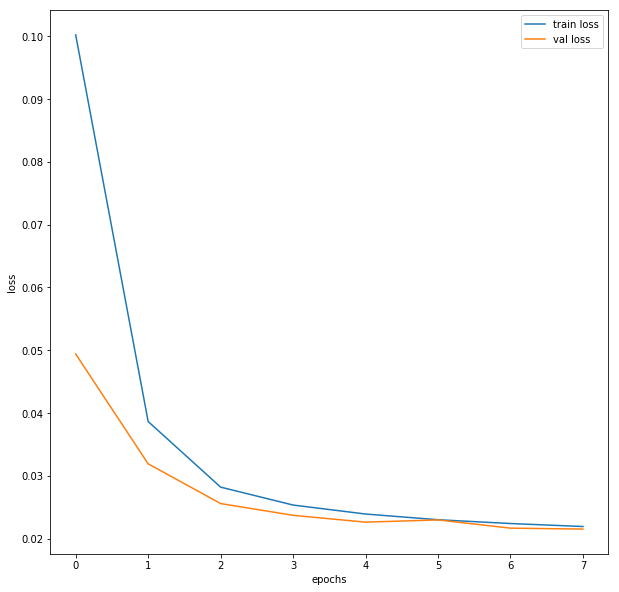

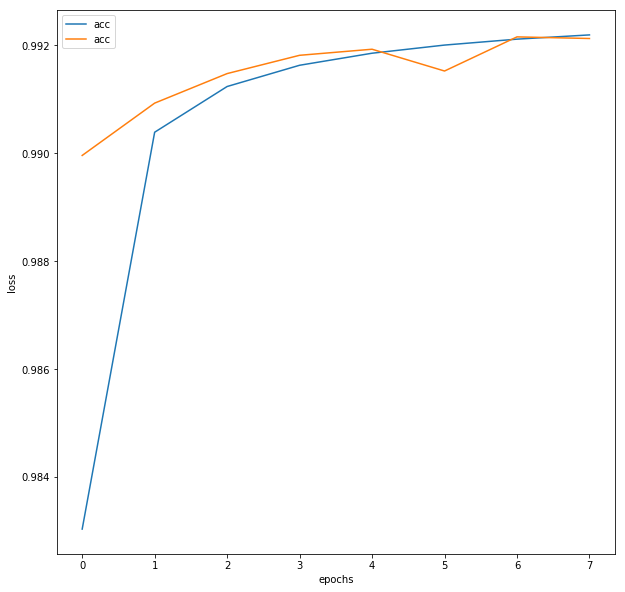

In [58]:
# Visualize learning
hist = model.history
plt.figure(figsize=(10, 10))
plt.plot(hist.history["loss"], label="train loss")
plt.plot(hist.history["val_loss"], label="val loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(hist.history["acc"], label="acc")
plt.plot(hist.history["val_acc"], label="acc")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [59]:
# testing trained model
scores = model.evaluate_generator(test_gen(batch_size), 
                                  steps=len(imgs_test)//batch_size, 
                                  verbose=1)
print("Acc: %.2f%%" % (scores[1]*100))

61/61 [==============================] - 33s 549ms/step
Acc: 99.22%


In [0]:
def run_inference_model(model, input_image, inf=False):
  input_image_shape = input_image.shape
  model_input_shape = model.get_input_shape_at(0)
  input_image = cv.resize(input_image, dsize=(model_input_shape[2], model_input_shape[1]), interpolation=cv.INTER_CUBIC)
  input_image = input_image.reshape((1, model_input_shape[1], model_input_shape[2], 1))
  
  t = time.time()
  output_image = model.predict(input_image)
  t = time.time() - t
  
  output_image = output_image.reshape((model_input_shape[1], model_input_shape[2]))
  output_image = cv.resize(output_image, dsize=(input_image_shape[1], input_image_shape[0]), interpolation=cv.INTER_NEAREST)
  if inf:
    print("Inference time: {} sec".format(round(t, 3)))
  
  return output_image

In [0]:
test_img_path = np.random.choice(imgs_test)

./images/2000000000033888_RT.jpg
./images_masked/2000000000033888_RT.jpg
./points/2000000000033888_RT.txt
Inference time: 0.109 sec


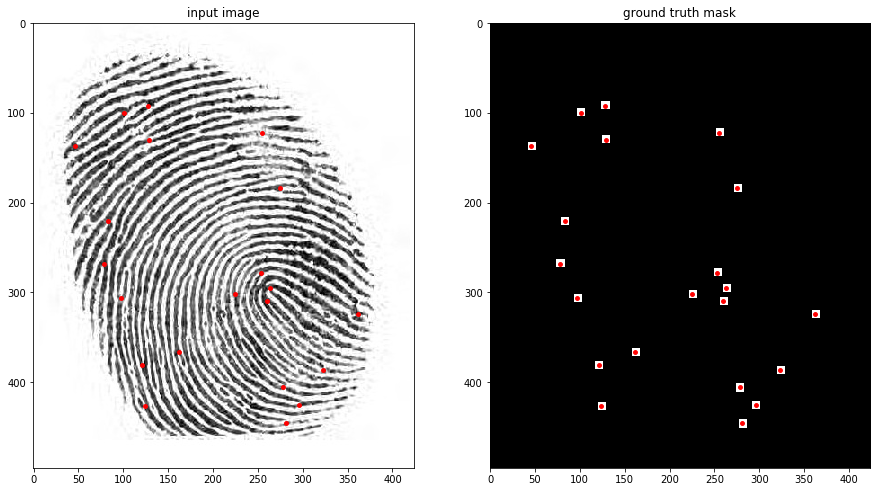

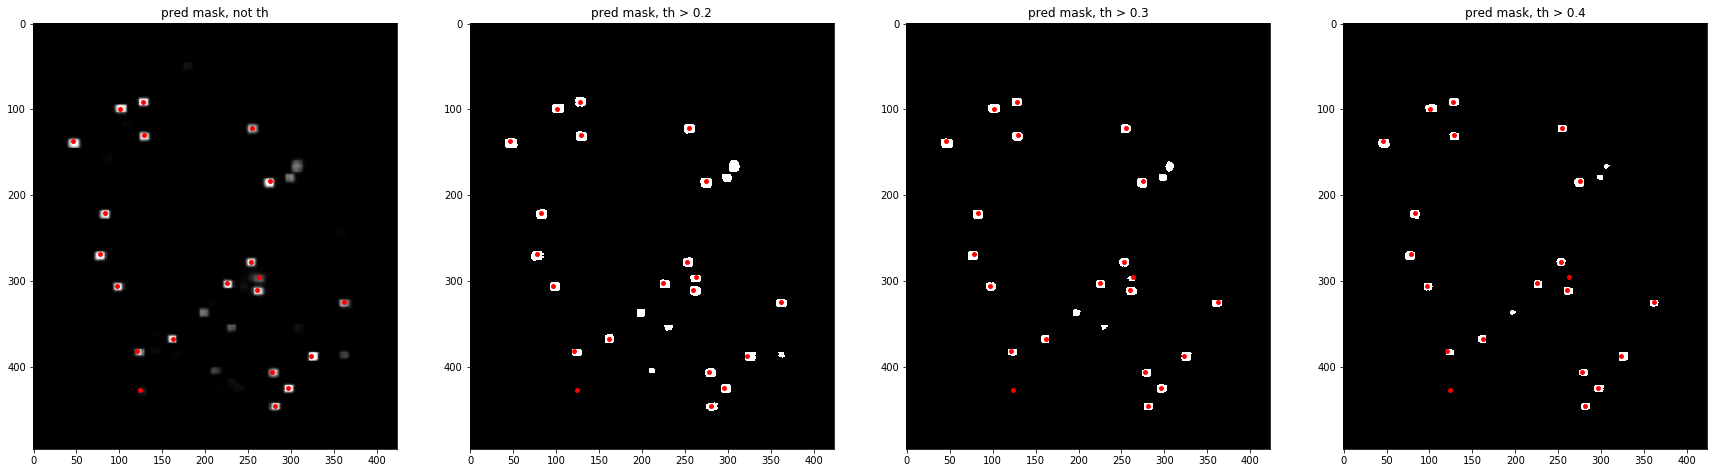

In [201]:
# visualizing results of model's inference
test_gt_mask_path = masks_test[imgs_test.index(test_img_path)]
test_gt_keypoints_path = labels_paths[os.path.basename(test_img_path).split(".")[0]]
print(test_img_path)
print(test_gt_mask_path)
print(test_gt_keypoints_path)

test_img, test_gt_keypoints = get_sample(test_img_path, test_gt_keypoints_path)
test_gt_mask = ((np.array(imgio.imread(test_gt_mask_path),dtype=np.float32)/255.0) > 0.5).astype(np.float32)

test_pred_mask = run_inference_model(model, test_img.copy(), inf=1)
test_pred_mask1 = test_pred_mask
th1 = 0.2
th2 = 0.3
th3 = 0.4
test_pred_mask2 = (test_pred_mask > th1).astype(np.float32)
test_pred_mask3 = (test_pred_mask > th2).astype(np.float32)
test_pred_mask4 = (test_pred_mask > th3).astype(np.float32)

show_test_sample((1, 2), [test_img, test_gt_mask], test_gt_keypoints, figsize=(15, 15),
                  titles=['input image', 'ground truth mask'])
show_test_sample((1, 4), [test_pred_mask1, test_pred_mask2, test_pred_mask3, test_pred_mask4], test_gt_keypoints,
                  titles=['pred mask, not th', 'pred mask, th > '+str(th1), 'pred mask, th > '+str(th2), 'pred mask, th > '+str(th3)])

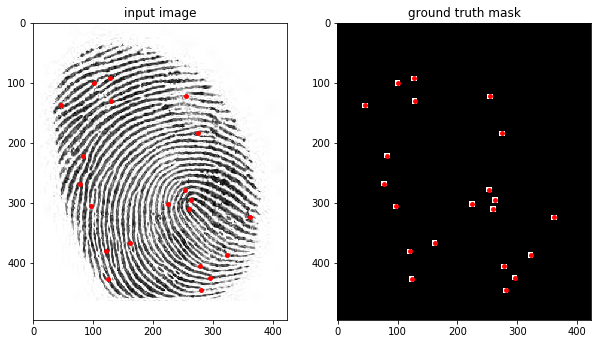

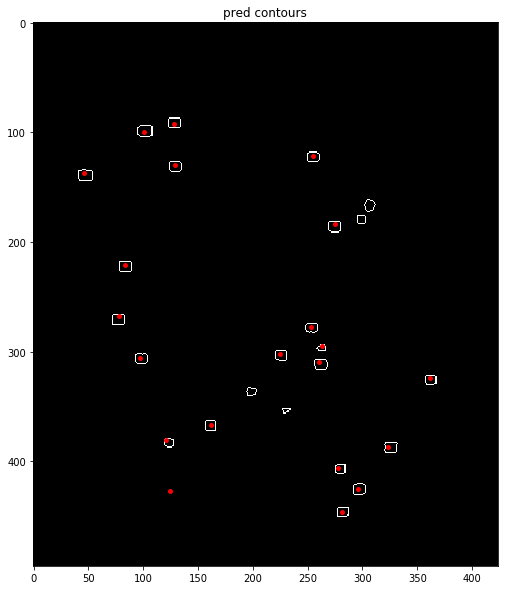

Image size:  (496, 424)
Num points:  21


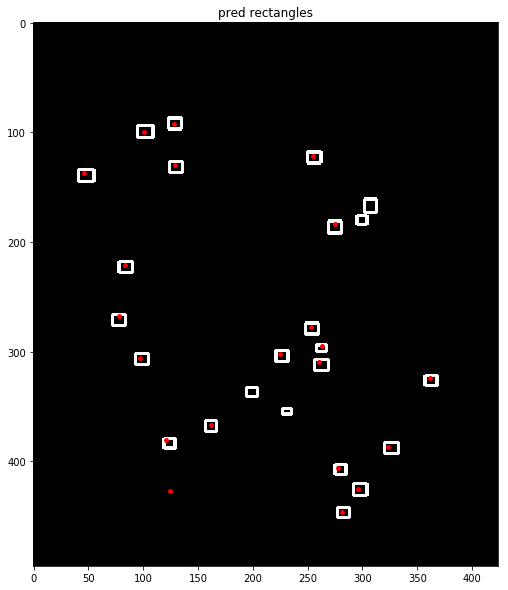

Image size:  (496, 424)
Num points:  21


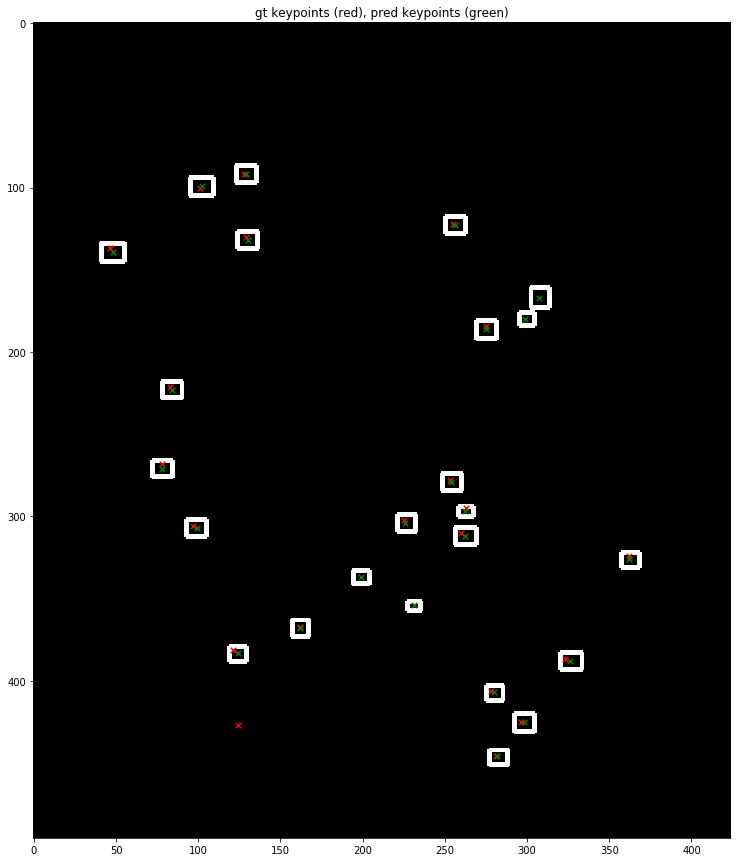

Num points (red):  21
Num points (green):  24


In [202]:
# post-proccessing
# vizualizing of searching of final predicted keypoints
show_test_sample((1, 2), [test_img, test_gt_mask], test_gt_keypoints, figsize=(10, 10),
                  titles=['input image', 'ground truth mask'])
th = 0.3
test_pred_mask = (test_pred_mask > th).astype(np.uint8)
img, contours, hierarchy = cv.findContours(test_pred_mask.copy(),cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

img1 = np.zeros(test_gt_mask.shape, dtype=np.uint8)
img2 = img1.copy()
img1 = cv.drawContours(img1, contours, -1, (255,255,255), 1)

kps1_rects = list()
kps1 = list()
for c in contours:
  rect = cv.boundingRect(c)
  if rect[2] * rect[3] < 6:
      continue
  kps1_rects.append(rect)
  kps1.append((rect[0] + rect[2] // 2, rect[1] + rect[3] // 2))
  img2 = cv.rectangle(img2,(rect[0],rect[1]),(rect[0]+rect[2],rect[1]+rect[3]),(255,255,255),2)
kps1_rects = np.array(kps1_rects)
kps1 = np.array(kps1)

show_sample2(img1, test_gt_keypoints, figsize=(10, 10), title='pred contours')
show_sample2(img2, test_gt_keypoints, figsize=(10, 10), title='pred rectangles')
#show_sample2(img2, kps1, figsize=(10, 10), title='pred keypoints')
show_keypoints(img2, test_gt_keypoints, kps1, title='gt keypoints (red), pred keypoints (green)')

def predict_keypoints(pred_hitmap):
  pred_hitmap = pred_hitmap.astype(np.uint8)
  img, contours, hierarchy = cv.findContours(pred_hitmap,cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
  
  kps = list()
  for c in contours:
    rect = cv.boundingRect(c)
    if rect[2] * rect[3] < 6:
      continue
    kps.append((rect[0] + rect[2] // 2, rect[1] + rect[3] // 2))
  
  return np.array(kps)

In [203]:
# scoring of model
euclidean_score_th = (math.sqrt((superpoint_size[0] / 2) ** 2 + (superpoint_size[0] / 2) ** 2) + superpoint_size[0] / 2) / 2
tp = 0
fp = 0
fn = 0
tn = 0
for test_img_path in imgs_test:
  test_gt_mask_path = masks_test[imgs_test.index(test_img_path)]
  test_gt_keypoints_path = labels_paths[os.path.basename(test_img_path).split(".")[0]]

  test_img, test_gt_keypoints = get_sample(test_img_path, test_gt_keypoints_path)
  test_gt_mask = ((np.array(imgio.imread(test_gt_mask_path),dtype=np.float32)/255.0) > 0.5).astype(np.float32)
  test_pred_mask = run_inference_model(model, test_img.copy())
  test_pred_mask = (test_pred_mask > 0.3).astype(np.float32)
  pred_keypoints = predict_keypoints(test_pred_mask)
  
  euclidean_scores = []
  for gt_kp in test_gt_keypoints:
    sc_arr = []
    prev_tp = tp
    flag = False
    for pred_kp in pred_keypoints:
      score = scipy.spatial.distance.euclidean(gt_kp, pred_kp)
      if (score <= euclidean_score_th and not flag):
        tp += 1
        flag = True
    
      sc_arr.append((pred_kp, score))
  
    if (prev_tp == tp):
      fn += 1
  
    euclidean_scores.append((gt_kp, sc_arr))

  fp += len(pred_keypoints)

fp = fp - tp
precision = (tp / (tp + fp))*100
recall = (tp / (tp + fn))*100
f1score = (2 * precision * recall) / (precision + recall)

print('TP: ', tp)
print('FP: ', fp)
print('TN: ', tn)
print('FN: ', fn)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1score: ', f1score)

TP:  10484
FP:  6249
TN:  0
FN:  3822
Precision:  62.6546345544732
Recall:  73.28393680973019
F1score:  67.55372273591288


In [75]:
! ls -l --block-size=MB
auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
        'name': name,
        'mimeType': 'application/octet-stream'
    }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                         media_body=media,
                                         fields='id').execute()
  print('File ID: {}'.format(created.get('id')))
    
  return created

save_file_to_drive('fingerprint_keypoints_detector.h5', './fingerprint_keypoints_detector.h5')

total 416MB
-rw-r--r-- 1 root root 104MB Oct 17 11:00 fingerprint_keypoints_detector.h5
drwxr-xr-x 2 root root   1MB Sep  3 17:27 images
drwxr-xr-x 2 root root   1MB Oct 17 08:43 images_aug
drwxr-xr-x 2 root root   1MB Oct 17 08:43 images_aug_masked
drwxr-xr-x 2 root root   1MB Oct 17 08:42 images_masked
drwxr-xr-x 2 root root   1MB Oct 17 08:41 patches
drwxr-xr-x 2 root root   1MB Oct 17 08:41 patches_aug
drwxr-xr-x 2 root root   1MB Sep  3 17:27 points
drwxr-xr-x 1 root root   1MB Aug 27 16:17 sample_data
-rw------- 1 root root 311MB Oct 17 08:40 Task.zip
-rw-r--r-- 1 root root   1MB Sep  3 17:29 ToDo.txt
File ID: 1OiJDheYFWCGquGYgnSkBemlMQoYAaM8Z


{'id': '1OiJDheYFWCGquGYgnSkBemlMQoYAaM8Z'}

Possibles improvements:<br>
1) Preprocessing: increasing the contrast and sharpness of the image, image filtering, more various augmentations<br>
2) Model learning: change size of superpixel masks, more longer learning, increasing depth of filters, may be other neural network architecture<br>
3) Postproccessing: NMS, image filtering, filtering based on distances metrics and euristics

### References

#### 1) https://arxiv.org/pdf/1811.06846.pdf
#### 2) https://arxiv.org/pdf/1809.01986.pdf
#### 3) https://arxiv.org/pdf/1809.10229v1.pdf
#### 4) https://vision.cornell.edu/se3/wp-content/uploads/2016/08/learning-detect-match.pdf
#### 5) http://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w9/DeTone_SuperPoint_Self-Supervised_Interest_CVPR_2018_paper.pdf
